# 💳Credit Card Fraud Detection : Dealing with  Class Imbalance

## 📤Load data and dependencies

Data Source : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


### Dependencies and Versions

* scikit-learn: 1.6.1
* xgboost: 2.1.3

In [ ]:
#import xgboost
#print(xgboost.__version__)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv(path + "/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
len(data)

284807

## 🧹 Data Cleaning

In [ ]:
# Check for duplicates
print(f'There are {data.duplicated().sum()} duplicates.')

# Remove duplicates
data.drop_duplicates(inplace=True)
print('All duplicates have been removed.')

There are 1081 duplicates.
All duplicates have been removed.


In [ ]:
# Check for missing values
print(f'Missing values present in dataset: {data.isna().any().any()}')

Missing values present in dataset: False


In [ ]:
# Change all column names to lowercase
data.columns = data.columns.str.lower()
data.columns

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'class'],
      dtype='object')

In [ ]:
# Drop unneccessary columns
data.drop(['time'], axis=1, inplace=True)

In [ ]:
df = data.copy()

## 📊 EDA: Cleaned data

### Target Variable : Check for Class Imbalance

In [ ]:
df['class'].value_counts().reset_index()

,class,count
0,0,283253
1,1,473


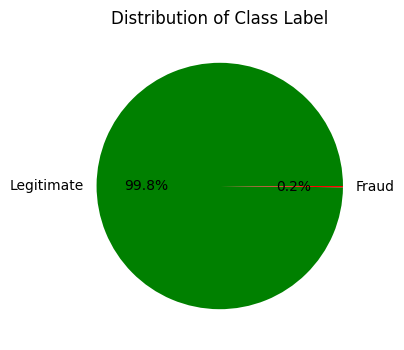

In [ ]:
## Create a pie plot to show the distribution of the class label
plt.figure(figsize=(6,4))
plt.pie(df['class'].value_counts(), labels=['Legitimate', 'Fraud' ], autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Distribution of Class Label')
plt.show()

#### 🔍 Observations

Because of the substantial class imbalance, we will explore resampling methods to address it.

# ➗ Data Splitting

In [ ]:
# Define X and y
X = df.drop('class', axis=1)
y = df['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🛠️ Data Preprocessing

In [ ]:
# Instantiate a scaler object
scaler = StandardScaler()

In [ ]:
# Normalize the training and test feature sets to improve model performance
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🧱✔️Model Building (Training & Evaluation)

In [ ]:
def build_and_evaluate_model(model, train_X, train_y, test_X, test_y, technique, threshold=None):
  model.fit(train_X, train_y)

  if threshold == None:
      # Make predictions
    y_pred = model.predict(test_X)
  else:
    y_pred_proba = model.predict_proba(test_X)[:, 1]  # Get fraud class probability
    y_pred = (y_pred_proba >= threshold).astype(int)

  # Create classification report
  print(f'Classification Report: {technique} \n')
  print(classification_report(test_y, y_pred, target_names=['legit', 'fraud']))

  # Create confusion matrix
  cm = confusion_matrix(test_y, y_pred)
  plt.figure(figsize=(3,3))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'],cbar=False) # format=decimal
  plt.xlabel('Predicted_Labels'),
  plt.ylabel('Actual_Labels')
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.title('Confusion Matrix')
  plt.show()

## Baseline model

In [ ]:
#logit= LogisticRegression(max_iter=1000, random_state=42)
logit= LogisticRegression(max_iter=1000, random_state=42)

Classification Report: Baseline 

              precision    recall  f1-score   support

       legit       1.00      1.00      1.00     56651
       fraud       0.85      0.58      0.69        95

    accuracy                           1.00     56746
   macro avg       0.92      0.79      0.84     56746
weighted avg       1.00      1.00      1.00     56746



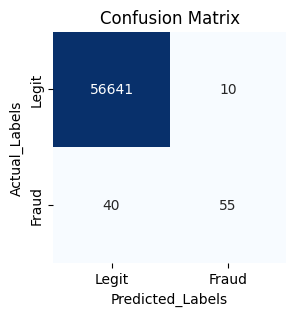

In [ ]:
build_and_evaluate_model(logit, X_train_scaled, y_train, X_test_scaled, y_test, 'Baseline')

### 🔍 Observations

* We achieve 100% accuracy, but given the class imbalance, `accuracy_score` is not the most reliable metric.

* **Precision for fraud** : Out of all the transactions the model flagged as fraudulent, 85% were indeed fraudulent. This indicates that the model is good at avoiding false positives - it's reliable in the sense that when it says something is fraud, it most likely is.

* **Recall for fraud** : The model catches 58% of all actual fraud case. 42% of fraud transactions are undetected by the model.

* TN = 56641 transactions that are actually legit was also flagged by the model as legit.
* FP = 10. The model incorrectly flagged 10 Legit transactions as fraud.
* <font color=firebrick>FN = 40. The model incorrectly flagged 40 Fraudulent transactions as legit.</font>
* TP = 55 transactions that are actually fraud was also flagged by the model as fraud.

**Our goal is to have ths FNs (misclassified fraud) as low as possible while maintaining a balance in Precision. If we miss the opportunity to detect fraud, it could lead to large losses.**

## 📈 Optimising model performance by addressing class imbalance

###Resampling technique : Oversampling (RandomOverSampler)

In [ ]:
ros = RandomOverSampler(random_state=42)

In [ ]:
# Resample training data
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train_scaled, y_train)

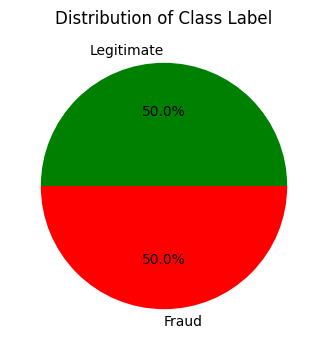

In [ ]:
## Create a pie plot to show the distribution of the class label
plt.figure(figsize=(6,4))
plt.pie(y_resampled_ros.value_counts(), labels=['Legitimate', 'Fraud' ], autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Distribution of Class Label')
plt.show()

Classification Report: RandomOverSampler 

              precision    recall  f1-score   support

       legit       1.00      0.98      0.99     56651
       fraud       0.06      0.87      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746



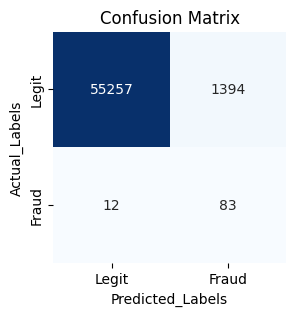

In [ ]:
build_and_evaluate_model(logit, X_resampled_ros, y_resampled_ros, X_test_scaled, y_test, 'RandomOverSampler')

#### 🔍 Observations

Appling the **RandomOverSampler** decreased our False Negatives (less missclassified fraud transactions) but at the same time we have significantly more False Positives which is not good for the overall performance of the model as reflected in the very low Precision of 6% and as an extension the f1-score of 11%.

###Resampling technique : Oversampling (SMOTE)

In [ ]:
smote = SMOTE(random_state=42)

In [ ]:
# Resample training data
X_resampled_sm, y_resampled_sm = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
# Distribution of class labels
y_resampled_sm.value_counts().reset_index()

,class,count
0,0,226602
1,1,226602


Classification Report: SMOTE 

              precision    recall  f1-score   support

       legit       1.00      0.97      0.99     56651
       fraud       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746



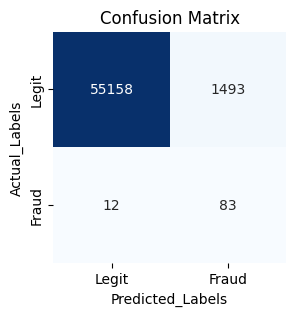

In [ ]:
build_and_evaluate_model(logit, X_resampled_sm, y_resampled_sm, X_test_scaled, y_test, 'SMOTE')

####🔍 Observations
Exhibits similar performance to the implementation with the RandomOverSampler, but with a slight increase in False Positives. The f1_score remains notably low.

###Resampling technique : Oversampling (ADASYN)

In [ ]:
adasyn = ADASYN(random_state=42)

In [ ]:
# Resample training data
X_resampled_adsn, y_resampled_adsn = adasyn.fit_resample(X_train_scaled, y_train)

In [ ]:
y_resampled_adsn.value_counts().reset_index()

,class,count
0,1,226618
1,0,226602


Classification Report: ADASYN 

              precision    recall  f1-score   support

       legit       1.00      0.91      0.95     56651
       fraud       0.02      0.92      0.03        95

    accuracy                           0.91     56746
   macro avg       0.51      0.91      0.49     56746
weighted avg       1.00      0.91      0.95     56746



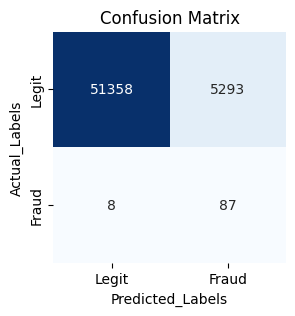

In [ ]:
build_and_evaluate_model(logit, X_resampled_adsn, y_resampled_adsn, X_test_scaled, y_test, 'ADASYN')

#### 🔍 Observations
Employing ADASYN has significantly reduced False Negatives, resulting in the highest Recall for spam observed so far. However, the rise in False Positives has negatively impacted Precision and f1_score for spam, making this model less suitable if we aim to maintain a balanced performance.

### Resampling technique: Undersampling (RandomUnderSampler)

In [ ]:
undersample = RandomUnderSampler(random_state=42)

In [ ]:
X_resampled_under, y_resampled_under = undersample.fit_resample(X_train_scaled, y_train)

In [ ]:
# Class Distribution
y_resampled_under.value_counts().reset_index()

,class,count
0,0,378
1,1,378


We have a lot less data to train on.

Classification Report: RandomUnderSampler 

              precision    recall  f1-score   support

       legit       1.00      0.97      0.99     56651
       fraud       0.05      0.87      0.09        95

    accuracy                           0.97     56746
   macro avg       0.52      0.92      0.54     56746
weighted avg       1.00      0.97      0.98     56746



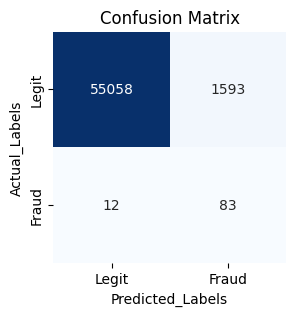

In [ ]:
build_and_evaluate_model(logit, X_resampled_under, y_resampled_under, X_test_scaled, y_test, 'RandomUnderSampler')

#### 🔍 Observations
The f1_score is still low. Not the best approach to use.

### Resampling technique : Undersampling (EditedNearestNeighbours)

ENN  removes samples that have a majority of their nearest neighbors belonging to a different class, effectively cleaning the decision boundary and reducing potential noise.

* ENN removes samples from the majority class (and sometimes the minority class) to refine the decision boundary.

In [ ]:
ENN = EditedNearestNeighbours()

In [ ]:
X_resampled_ENN, y_resampled_ENN = ENN.fit_resample(X_train_scaled, y_train)

In [ ]:
y_resampled_ENN.value_counts().reset_index()

,class,count
0,0,226465
1,1,378


Samples have been removed from the majority class, the minority class remain unchanged.

Classification Report: EditedNearestNeighbours 

              precision    recall  f1-score   support

       legit       1.00      1.00      1.00     56651
       fraud       0.86      0.63      0.73        95

    accuracy                           1.00     56746
   macro avg       0.93      0.82      0.86     56746
weighted avg       1.00      1.00      1.00     56746



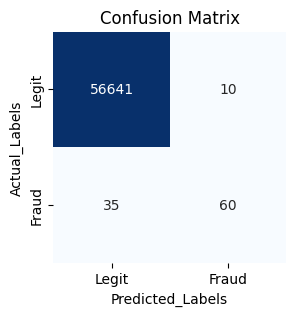

In [ ]:
build_and_evaluate_model(logit, X_resampled_ENN, y_resampled_ENN, X_test_scaled, y_test, 'EditedNearestNeighbours')

#### 🔍 Observations
Now that the False Positives have decreased significantly, our f1-score has improved. However, the Recall remains too low for our specific need of detecting spam.

### Cost-Sensitive Learning : Balanced Class Weights

Given that only 0.2% of samples are labeled as Fraud, while 99.8% are Legitimate Transactions, using class weight adjustments is a good approach instead of oversampling or undersampling. This can help to prevent the model overfitting on artificial samples and also will stop us from having to remove valuable data. Additionally this method can help the model give more importance to our Spam class.


In [ ]:
logit = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

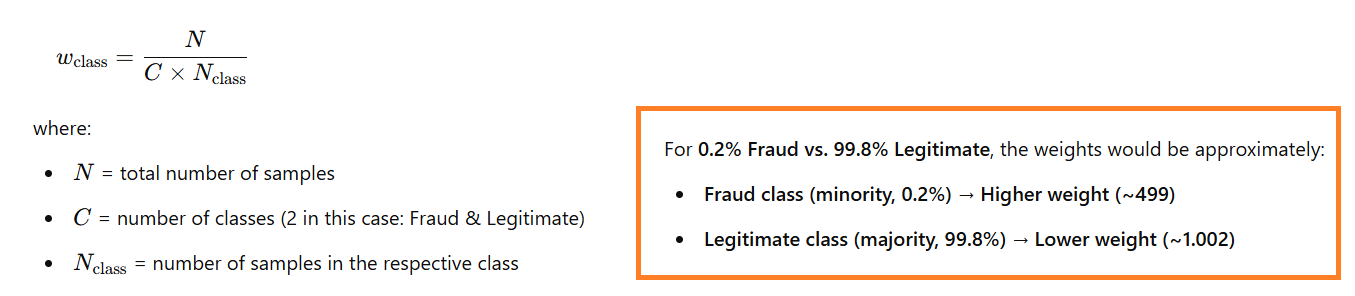

Classification Report: Balanced Class Weights 

              precision    recall  f1-score   support

       legit       1.00      0.98      0.99     56651
       fraud       0.06      0.87      0.10        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746



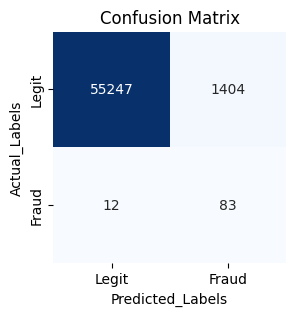

In [ ]:
build_and_evaluate_model(logit, X_train_scaled, y_train, X_test_scaled, y_test, 'Balanced Class Weights')

### Cost-Sensitive : Custom Class Weights

In [ ]:
logit = LogisticRegression(class_weight={0:1, 1:1000}, max_iter=1000, random_state=42)

Classification Report: Custom Class Weights 

              precision    recall  f1-score   support

       legit       1.00      0.96      0.98     56651
       fraud       0.04      0.87      0.07        95

    accuracy                           0.96     56746
   macro avg       0.52      0.92      0.52     56746
weighted avg       1.00      0.96      0.98     56746



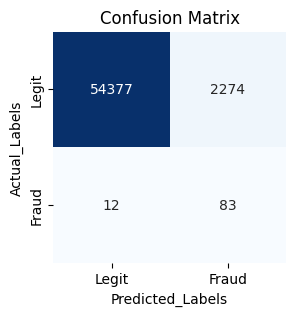

In [ ]:
build_and_evaluate_model(logit, X_train_scaled, y_train, X_test_scaled, y_test, 'Custom Class Weights')

### Cost_Sensitive: Implement different algorithms

#### Support Vector Classification

* Dataset is large, so it takes too long  to build the model.

#### Random Forest

* Dataset is large, model building is slow.

#### XGBoost (Extreme Gradient Boosting)

XGBoost is an optimized gradient boosting library that works exceptionally well for fraud detection. It provides scale_pos_weight, which adjusts the weight of the minority class.

In [ ]:
xgb = XGBClassifier(n_estimators = 100, scale_pos_weight=fraud_weight, random_state=42, use_label_encoder=False,verbose=1, n_jobs=-1)

Classification Report: XGBoost 

              precision    recall  f1-score   support

       legit       1.00      1.00      1.00     56651
       fraud       0.95      0.77      0.85        95

    accuracy                           1.00     56746
   macro avg       0.97      0.88      0.92     56746
weighted avg       1.00      1.00      1.00     56746



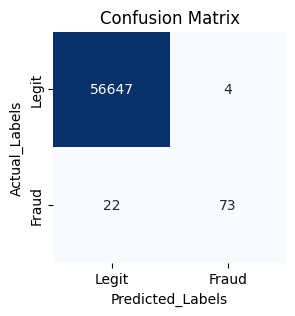

In [ ]:
build_and_evaluate_model(xgb, X_train_scaled, y_train, X_test_scaled, y_test, 'XGBoost')

## Bayesian Optimization ( Optuna)

We can implement optuna to tune the hyperparameters of our XGBoost model.

In [ ]:
# install optuna
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.9 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.metrics import recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight


# Define Optuna objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_uniform('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    # Train XGBoost model
    model = XGBClassifier(**params, scale_pos_weight=fraud_weight, use_label_encoder=False, eval_metric='logloss', verbose=1, n_jobs=-1)
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get fraud class probability

    # Convert probabilities to class labels using a low threshold (improves recall)
    threshold = 0.5  # You can tune this further
    y_pred = (y_pred_proba >= threshold).astype(int)
    #---------------------------------------------------------------------
    # Calculate recall
    #recall = recall_score(y_test, y_pred)
    #return recall
    #---------------------------------------------------------------------
    # Calculate F1-score
    f1 = f1_score(y_test, y_pred)
    return f1

# Run Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximise f1-score for spam
study.optimize(objective, n_trials=50)

[I 2025-04-14 13:23:31,595] A new study created in memory with name: no-name-17fe6c8a-d3f2-45a2-8267-b34157355847
[I 2025-04-14 13:23:37,030] Trial 0 finished with value: 0.2351233671988389 and parameters: {'n_estimators': 180, 'max_depth': 3, 'learning_rate': 0.035253704443998474, 'subsample': 0.5886139588195565, 'colsample_bytree': 0.9481932905262745, 'gamma': 0.21140900171553623, 'min_child_weight': 1}. Best is trial 0 with value: 0.2351233671988389.
[I 2025-04-14 13:23:59,806] Trial 1 finished with value: 0.8505747126436781 and parameters: {'n_estimators': 713, 'max_depth': 9, 'learning_rate': 0.12244823148307396, 'subsample': 0.5496080690489697, 'colsample_bytree': 0.9238185234269278, 'gamma': 0.7610762733473969, 'min_child_weight': 1}. Best is trial 1 with value: 0.8505747126436781.
[I 2025-04-14 13:24:11,031] Trial 2 finished with value: 0.8539325842696629 and parameters: {'n_estimators': 191, 'max_depth': 12, 'learning_rate': 0.10180820258779626, 'subsample': 0.8008572134491379

In [ ]:
# Best parameters
print("Best f1_score:", study.best_value)
print("Best parameters:", study.best_trial.params)

Best f1_score: 0.8837209302325582
Best parameters: {'n_estimators': 993, 'max_depth': 4, 'learning_rate': 0.1260999364534706, 'subsample': 0.7223772600151763, 'colsample_bytree': 0.89362118996305, 'gamma': 0.0870262821607588, 'min_child_weight': 2}


Classification Report: XGBoost + Optuna (threshold = 0.5) 

              precision    recall  f1-score   support

       legit       1.00      1.00      1.00     56651
       fraud       0.97      0.79      0.87        95

    accuracy                           1.00     56746
   macro avg       0.99      0.89      0.94     56746
weighted avg       1.00      1.00      1.00     56746



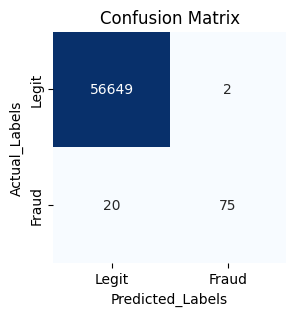

In [ ]:
xgb = XGBClassifier(**study.best_trial.params, scale_pos_weight=fraud_weight, random_state=42, use_label_encoder=False,verbose=1, n_jobs=-1)
build_and_evaluate_model(xgb, X_train_scaled, y_train, X_test_scaled, y_test, 'XGBoost + Optuna (threshold = 0.5)', threshold=0.5)

### Plotting Precision-Recall Tradeoff and Determining Best Threshold for Fraud Detection

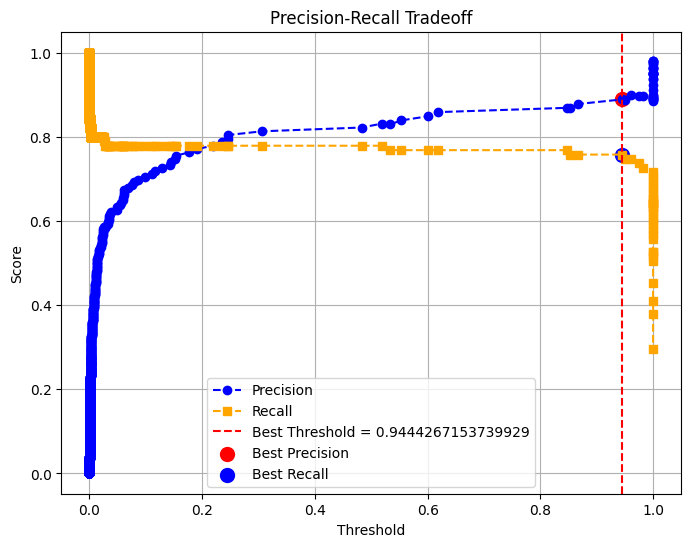

At threshold 0.9444: Precision = 0.8889, Recall = 0.7579


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# Predict probabilities
y_pred_proba = xgb.predict_proba(X_test)[:, 1]  # Get fraud class probability

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)


# Compute F1-score
f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)  # Avoid division by zero
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]


# Plot Precision and Recall against Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", linestyle="--", marker="o", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", linestyle="--", marker="s", color="orange")

# Highlight best threshold
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best Threshold = {best_threshold}")
plt.scatter(best_threshold, precision[best_idx], color='red', s=100, label="Best Precision")
plt.scatter(best_threshold, recall[best_idx], color='blue', s=100, label="Best Recall")

# Labels and Legend
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff")
plt.legend()
plt.grid()
plt.show()

print(f"At threshold {best_threshold:.4f}: Precision = {precision[best_idx]:.4f}, Recall = {recall[best_idx]:.4f}")


Classification Report: XGBoost + Optuna 

              precision    recall  f1-score   support

       legit       1.00      1.00      1.00     56651
       fraud       0.99      0.74      0.84        95

    accuracy                           1.00     56746
   macro avg       0.99      0.87      0.92     56746
weighted avg       1.00      1.00      1.00     56746



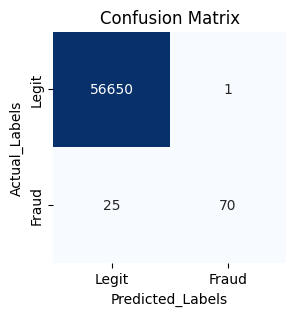

In [ ]:
build_and_evaluate_model(xgb, X_train_scaled, y_train, X_test_scaled, y_test, 'XGBoost + Optuna', threshold=best_threshold)

Classification Report:
              precision    recall  f1-score   support

       legit       1.00      1.00      1.00     56651
       fraud       0.99      0.73      0.84        95

    accuracy                           1.00     56746
   macro avg       0.99      0.86      0.92     56746
weighted avg       1.00      1.00      1.00     56746



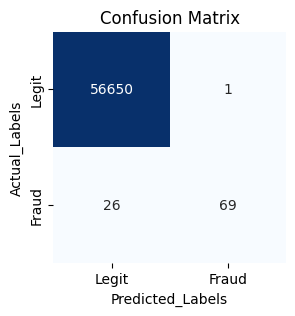

In [ ]:
xgb = XGBClassifier(**study.best_trial.params, scale_pos_weight= fraud_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
# Predict probabilities
y_pred_proba = xgb.predict_proba(X_test)[:, 1]  # Get fraud class probability

# Convert probabilities to class labels using a low threshold (improves recall)
threshold = 0.9714 # You can tune this further
y_pred = (y_pred_proba >= threshold).astype(int)

# Create classification report
print(f'Classification Report:' )
print(classification_report(y_test, y_pred, target_names=['legit', 'fraud']))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'],cbar=False) # format=decimal
plt.xlabel('Predicted_Labels'),
plt.ylabel('Actual_Labels')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Confusion Matrix')
plt.show()